In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as ss
from scipy import stats
import plotly.express as px
from scipy.stats import mannwhitneyu
import scipy
from tqdm import tqdm
import pingouin as pg

%matplotlib inline

In [2]:
#  файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе 
# (А – контроль, B – целевая группа) 
groups_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-berezin-33/Проект_2_groups.csv', sep=';')

In [3]:
# дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
groups_add_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-berezin-33/Проект_2_group_add.csv')

In [4]:
# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
activ_studs_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-berezin-33/Проект_2_active_studs.csv')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [5]:
# файл с информацией об оплатах пользователей в дни проведения эксперимента. 
checks_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-berezin-33/Проект_2_checks.csv', sep=';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


#### Для анализа A/B теста нам потребуется: 

1. Проверить данные.
2. Определить метрики по которым будем отслеживать изменения и ответить на ряд вопросов:
    
    - Имеются ли различия в показателях и с чем они могут быть связаны?
    - Являются ли эти различия статистически значимыми?
    - Стоит ли запускать новую механику на всех пользователей?

## Исследуем данные.

#### Сет с первыми данными.

In [6]:
groups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [7]:
groups_df.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [8]:
groups_df.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [9]:
groups_df.isna().sum()

id     0
grp    0
dtype: int64

#### Сет с дополнительными данными

In [10]:
groups_add_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [11]:
groups_add_df.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [12]:
groups_add_df.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [13]:
groups_add_df.isna().sum()

id     0
grp    0
dtype: int64

#### Сет с информацией о пользователях о зашедших на платформу во время теста.

In [14]:
activ_studs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [15]:
activ_studs_df.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [16]:
activ_studs_df.isna().sum()

student_id    0
dtype: int64

In [17]:
activ_studs_df = activ_studs_df.rename(columns={'student_id' : 'id'})

#### Информация о пользователях совершивших оплату во время теста

In [18]:
checks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [19]:
checks_df.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [20]:
checks_df.isna().sum()

student_id    0
rev           0
dtype: int64

In [21]:
# Изменили имя колонки что бы объеденить датасеты.
checks_df = checks_df.rename(columns={'student_id' : 'id'})

#### Объединим таблицы в одну, т.к. у нас есть данные которые покажут нам поведение пользователей во время проведения теста.
- Что бы провести объединение нужно будет изменить название колонок, по которым будем соединять таблицы.

In [22]:
# Дополонили изначальный датасед данными, после поступления новой информации.
groups_df = pd.concat([groups_df, groups_add_df], ignore_index=True)

In [23]:
# Соединяем таблицы  checks_df и groups_df, по колноке id.
df = groups_df.merge(checks_df, how='left', on='id')

In [24]:
# Получили таблицу с полным набором данных.
df

,id,grp,rev
0,1489,B,NaN
1,1627,A,990.0
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN
...,...,...,...
74571,200247820,B,NaN
74572,201032527,B,NaN
74573,201067612,B,NaN
74574,201067653,B,NaN


#### Теперь из полученного набора данных вытащим только активных пользователей.

In [25]:
active_student = df.merge(activ_studs_df, how='inner', on='id')

In [26]:
active_student

,id,grp,rev
0,1627,A,990.0
1,2085,B,NaN
2,2215,B,NaN
3,3391,A,NaN
4,3401,B,NaN
...,...,...,...
8336,5760471,B,NaN
8337,5777081,B,NaN
8338,5870856,A,NaN
8339,5945085,B,NaN


### Имеем в результате два датасета, с полным набором данных df и с активными пользователями active_student.

In [27]:
# Проверяем соотношения контрольной и экспериментальной групп в полном наборе данных.
df.grp.value_counts(normalize=True).round(2)

B    0.8
A    0.2
Name: grp, dtype: float64

In [28]:
df.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

In [29]:
# Проверяем соотношения контрольной и экспериментальной групп в данных с активными пользователями.
active_student.grp.value_counts(normalize=True).round(2)

B    0.82
A    0.18
Name: grp, dtype: float64

In [30]:
active_student.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

### Как мы видим соотношение контрольной и экспериментальной групп примерно одинаковое как в данных с активными пользователями, так и в полном наборе данных.  Так же стоит отметить, что группа В - является контрольной, а группа А - тестовой.

## Теперь можем проверить распределение данных на нормальность.

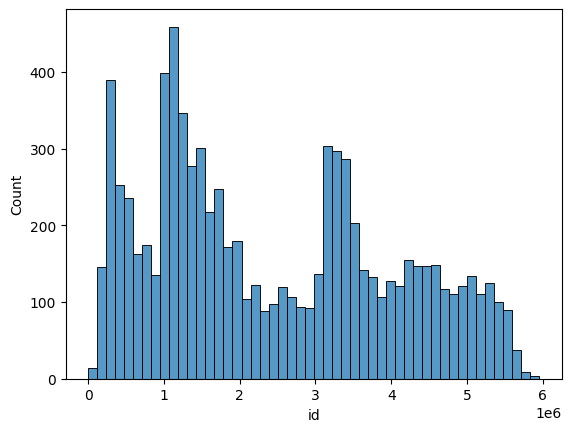

In [31]:
# Даннные по активным пользователям.
sns.histplot(active_student.id, kde = False, bins=50)

### Так же проведем проверку на нормальность и в датасете df.

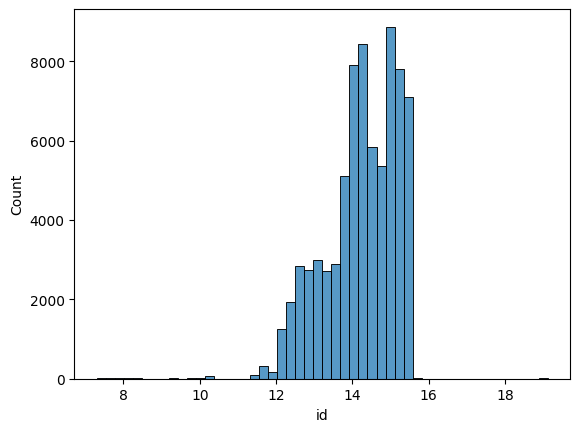

In [32]:
# Данные по всем пользователям.
sns.histplot(np.log(df.id), kde = False, bins=50)

### Для подтверждения наших графиков, проведем тест на проверку нормальности.

In [33]:
# Общая группа.
scipy.stats.normaltest(df.id)

NormaltestResult(statistic=232940.64304841086, pvalue=0.0)

In [34]:
# Группа активных пользователей.
scipy.stats.normaltest(active_student.id)

NormaltestResult(statistic=4164.056931561523, pvalue=0.0)

In [35]:
df_A = df.query('grp == "A"')
df_B = df.query('grp == "B"')

In [36]:
stats.mannwhitneyu(df_A.id, df_B.id, alternative='two-sided')

MannwhitneyuResult(statistic=437942087.0, pvalue=0.3951511185988269)

### Уровень значимости установим в 0,05. После проведенных тестов мы можем с уверенностью сказать, что распределение в группах у нас является не нормальным. Т.к. полученный уровень значимости явно меньше чем 0,05. 


### Считаем CR в группе А и В. Кол-во ключевых действий (совершение оплаты), в группе А - 78, а в группе В - 314. 
Получаем значение для группы А в размере 5.1% и в группе В 4.6%, уровень конверсии достаточно хорошо вырос у пользователей в тестовой группе.

In [67]:
group_A = active_student.query('grp == "A"')
group_B = active_student.query('grp == "B"')
    
group_a_pay = active_student.query('rev != 0 and grp == "A"')
group_b_pay = active_student.query('rev != 0 and grp == "B"')

In [72]:
((group_a_pay.rev.count() / group_A.id.count()).round(3))*100

5.1

In [70]:
((group_b_pay.rev.count() / group_B.id.count()).round(3))*100

1       15.1
2       14.2
4        9.2
5        1.4
6        1.2
        ... 
8335     0.0
8336     0.0
8337     0.0
8339     0.0
8340     0.0
Name: id, Length: 6803, dtype: float64

### Проведем тест Тьюке, для выявления различий в группах с активными пользователями и со всеми пользователями.

In [42]:
# Активные пользователи.
active_student.pairwise_tukey(dv='rev', between='grp').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,933.59,1257.879,-324.289,103.482,-3.134,0.002,-0.396


In [43]:
# Все пользователи.
df.pairwise_tukey(dv='rev', between='grp').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,860.71,1108.825,-248.115,81.704,-3.037,0.003,-0.327


### Считаем ARPAU в группе А и В по активным студентам.

In [44]:
group_A = active_student.query('grp == "A"')
arpau_A = (group_A.rev.sum() / group_A.id.count()).round(2)
arpau_A

47.35

In [45]:
group_B = active_student.query('grp == "B"')
arpau_B = (group_B.rev.sum() / group_B.id.count()).round(2)
arpau_B

58.06

In [46]:
(active_student.rev.sum() / active_student.id.count()).round(2)

56.08

#### Можно предположить что такая разница обусловенна размером тестовой и контрольной групп.

## Считаем ARPU в группе А и В по всем студентам.

In [47]:
df_group_A = df.query('grp == "A"')
df_arpu_A = (df_group_A.rev.sum() / df_group_A.id.count()).round(2)
df_arpu_A

6.27

In [48]:
df_group_B = df.query('grp == "B"')
df_arpu_B = (df_group_B.rev.sum() / df_group_B.id.count()).round(2)
df_arpu_B

8.04

In [49]:
df_arpu = (df.rev.sum() / df.id.count()).round(2)
df_arpu

7.69

In [38]:
# Посмотрим на средние и медиану по группам активных студентов.
active_student.groupby('grp').agg({'rev' : ['count', 'mean', 'median', 'sum']})

rev                                  
    count         mean  median          sum
grp                                        
A      78   933.589744   585.0   72820.0000
B     314  1257.878992  1140.0  394974.0035

In [66]:
# Посмотрим на средние и медиану по группам всех студентов.
df.groupby('grp').agg({'rev' : ['count', 'mean', 'median', 'sum']})

rev                                 
    count         mean median          sum
grp                                       
A     107   860.710280  690.0   92096.0000
B     434  1108.824893  935.0  481230.0036

### Из полученных данных видно, как сильно различаются средние значения и медианна. Для подтвержения полученных данных проведем бутстрап медиан и средних.

### Наша нулевая гипотиза заключается в том, что: "Нет ни какого различия между группами А и В".Мы делаем это для того, что бы узнать какова вероятность получить результат  в 555, при отсутсвии каких либо различий между группами А и Б. Что бы не было различий, мы должны перемешать эти группы, чтобы они были однородными, т.е. мы как бы забываем где у нас тестовая группа, а где контрольная.

In [50]:
active_student.grp.value_counts().values

array([6803, 1538])

In [51]:
active_student.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [52]:
group_size = active_student.grp.value_counts().values

In [53]:
n = 1000         # кол-во симуляций
result = []       # куда сохраним результат симуляций
base_diff = 1140.0 - 585.0  # разница в медиане

# Цикл с бутстрапом
for _ in tqdm(range(n)):
    b = active_student.sample(group_size[0], replace=True)['rev'].median()
    a = active_student.sample(group_size[1], replace=True)['rev'].median()
    result.append(np.abs(b-a) >= base_diff)

100%|██████████| 1000/1000 [00:02<00:00, 480.92it/s]


In [54]:
np.mean(result)

0.062

In [55]:
base_diff_mean = 1257.878992 - 933.589744
result_mean = []
for _ in tqdm(range(n)):
    b = active_student.sample(group_size[0], replace=True)['rev'].mean()
    a = active_student.sample(group_size[1], replace=True)['rev'].mean()
    result_mean.append(np.abs(b-a) >= base_diff_mean)

100%|██████████| 1000/1000 [00:02<00:00, 458.12it/s]


In [56]:
np.mean(result_mean)

0.006

### Ответы на интересующие нас вопросы:

##### На какие метрики Вы смотрите в ходе анализа и почему?
В данной работе рассматривал ARPU, CR, т.к. были данные по оплатам пользователей за период проведения теста. 

##### Имеются ли различия в показателях и с чем они могут быть связаны?
Мы имеем достаточно сильное различе по всем трем метрикам. Скорее всего это может быть связанно с вовлеченностью аудитории в разных группах. Можно сделать предположение о том, что группы так же различались по увиденной страничке оплаты либо же с шагами которые предшествуют самой оплате. Так же различия в группах подтверждаются тестом Тьюке.

В котором гипотезы были следующими:
- H0: Разницы между тестовой и контрольной группами нет.
- H1: Разница между тестовой и контрольной группами есть.

##### Являются ли эти различия статистически значимыми?
Однозначно являются. Это было проверенно с помошью бутстрапа.

В нашем случае нулевая гипотеза звучала так: 
- H0: Разницы между тестовой и контрольной группами нет
- H1: Разница между тестовой и контрольной группами есть

В нашем случае p-уровень значимости был равен 0.05, что означает, если мы получим значение меньше заданного то нулевая гипотеза будет отклонена, а это значит что мы примем Н1. Если p-value привысит заданные значение, то мы примем Н0.

После проведения трех тестов мы получили следующие результаты: 

##### Бутстрап средних
- p-value равно 0.003%
Используемый тест позволяет отклонить Н0, т.к. полученный p-уровень значимости оказался ниже заданного.

##### Бутстрап медиан
- p-value равно 0.068%
Используемый тест позволяет отклонить Н1, т.к. полученный p-уровень значимости оказался выше заданного.

##### Вывод:
Не смотря на то что Бутстрап средних, дал однозначно понять что нам необходимо отклонить Н0, а Бутстрап медиан говорит об обратном, а показатели конверсии и средние показатели в тестовой группе достаточно сильно выросли при новом дизайне, то я склонен рекомендовать распространить новый вариант оплаты на всех пользователей, т.к. р-value показывает нам что вероятность ошибиться равна 0,003% а это очень низкий показатель.